# Assignment 4

Tanzil

# 1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_resume = pd.read_csv('resume.csv')

In [3]:
df_resume.shape

(2484, 4)

In [4]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [5]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [6]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [9]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "skills.jsonl"

In [10]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [11]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [12]:
doc = nlp("Tanzil is a master student of Internet of Things")
doc.ents

(Tanzil, Internet of Things)

## 3. Let's try to extract skills from this resume.csv

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
78,16877897,ASSISTANT MANAGER - HR www...,"<div class=""fontsize fontface vmargins hmargin...",HR
1983,27066370,PROJECT COORDINATOR/SITE ACQUISITION ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
2119,20470943,ADMINISTRATIVE ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS
144,67582956,PROJECT DESIGNER Summary Te...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
520,30741799,COURT APPOINTED SPECIAL ADVOCATE FOR ...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE


In [14]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [18]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         HR MANAGER/BUSINESS PARTNER           Summary    A Human Resources Business Partner with extensive experience aligning HR strategy with business strategy for assigned business groups. Employee Relations Coaching/Mentoring Talent Acquisition Salary Planning Organizational Design Workforce Pl'

In [19]:
preprocessing(random_resume[:300])

'hr manager business partner summary a human resources business partner extensive experience align hr strategy business strategy assign business group employee relations coaching mentoring talent acquisition salary planning organizational design workforce pl'

In [20]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [21]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
78,16877897,ASSISTANT MANAGER - HR www...,"<div class=""fontsize fontface vmargins hmargin...",HR,assistant manager hr www.linkedin.com/in/suman...
1983,27066370,PROJECT COORDINATOR/SITE ACQUISITION ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,project coordinator site acquisition and const...
2119,20470943,ADMINISTRATIVE ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,administrative assistant summary determined pr...
144,67582956,PROJECT DESIGNER Summary Te...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,project designer summary team orient client fo...
520,30741799,COURT APPOINTED SPECIAL ADVOCATE FOR ...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,court appoint special advocate for abused and ...


## 4. Let's really extract skills!!

In [23]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [24]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [26]:
df_resume.Skills.iloc[0]

['library',
 'database',
 'collaboration',
 'business',
 'windows',
 'deployment',
 'javascript',
 'support',
 'operating systems',
 'security',
 'monitoring']

## Additional features or improvements inspired by spaCy’s capabilities

In [27]:
import spacy
from spacy.matcher import Matcher
from collections import defaultdict

# Load spaCy model
nlp = spacy.load("en_core_web_md")

# Define patterns for Matcher to find work experience, certifications, etc.
work_experience_patterns = [
    [{"POS": "PROPN", "OP": "+"}, {"LOWER": "at"}, {"POS": "PROPN", "OP": "+"}],
    [{"POS": "NOUN", "OP": "+"}, {"POS": "ADP"}, {"POS": "PROPN", "OP": "+"}],
    [{"POS": "VERB"}, {"POS": "NOUN", "OP": "+"}, {"LOWER": "at"}, {"POS": "PROPN", "OP": "+"}],
]

contact_info_patterns = [
    [{"LIKE_EMAIL": True}],
]

certification_patterns = [
    [{"LOWER": "certified"}, {"IS_ALPHA": True, "OP": "*"}],
    [{"LOWER": "certificate"}, {"IS_ALPHA": True, "OP": "*"}],
    [{"LOWER": "certification"}, {"IS_ALPHA": True, "OP": "*"}],
]

# Initialize Matcher and add patterns
matcher = Matcher(nlp.vocab)
matcher.add("WORK_EXPERIENCE", work_experience_patterns)
matcher.add("CONTACT_INFO", contact_info_patterns)
matcher.add("CERTIFICATION", certification_patterns)

# Standard skills for semantic matching
standard_skills = ["machine learning", "data analysis", "project management"]
standard_skills_docs = [nlp(text) for text in standard_skills]

# Function to process resume text and extract information
def process_resume(text):
    doc = nlp(text)
    results = defaultdict(list)
    
    # Extract entities using Matcher
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        label = nlp.vocab.strings[match_id]
        results[label].append(span.text)
    
    # Semantic skill matching
    for token in doc:
        for skill_doc in standard_skills_docs:
            if token.similarity(skill_doc) > 0.7:  # Threshold for similarity
                results["SKILLS"].append(skill_doc.text)
    
    # Normalize job titles in WORK_EXPERIENCE (example)
    job_title_normalization = {
        "software dev": "Software Developer",
        "software engineer": "Software Developer",
        "project manager": "Project Manager",
    }
    for i, job in enumerate(results["WORK_EXPERIENCE"]):
        for variation, standard in job_title_normalization.items():
            if variation in job.lower():
                results["WORK_EXPERIENCE"][i] = job.replace(variation, standard)
    
    # Ensure uniqueness and return results
    for key in results:
        results[key] = list(set(results[key]))  # Remove duplicates
    
    return dict(results)

# Example resume text
resume_text = """
John Doe, software dev at Tech Innovations Inc., certified in Data Science.
Email: john.doe@example.com. Experienced in ML, analytics, and leading teams.
"""

# Process the resume text
processed_info = process_resume(resume_text)
print(processed_info)


{'WORK_EXPERIENCE': ['dev at Tech Innovations', 'dev at Tech Innovations Inc.', 'dev at Tech', 'Software Developer at Tech Innovations', 'Software Developer at Tech', 'Software Developer at Tech Innovations Inc.'], 'CERTIFICATION': ['certified in', 'certified', 'certified in Data Science', 'certified in Data'], 'CONTACT_INFO': ['john.doe@example.com'], 'SKILLS': ['data analysis', 'project management']}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8784\365495833.py:50: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  if token.similarity(skill_doc) > 0.7:  # Threshold for similarity


## Key Enhancements:
### Integrated Matcher: Patterns for work experience, contact info, and certifications are defined and added to the Matcher. This setup allows for flexible and powerful pattern matching in the resume text.
### Semantic Skill Matching: Implemented to match skills in the resume text with a predefined list of standard skills based on semantic similarity.
### Normalization: An example normalization for job titles in work experience is shown. This can be expanded to other areas like skills and certifications for consistency.

## 5. Visualization

In [63]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [64]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(58, 6)

In [65]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [66]:
all_skill

array(['documentation', 'wireless network', 'schedule', ..., 'debugging',
       'visual basic', 'software'], dtype='<U44')

In [67]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [68]:
counting

OrderedDict([('support', 54),
             ('software', 47),
             ('business', 43),
             ('security', 38),
             ('design', 38),
             ('database', 34),
             ('server', 32),
             ('project management', 28),
             ('windows', 25),
             ('documentation', 22)])

<BarContainer object of 10 artists>

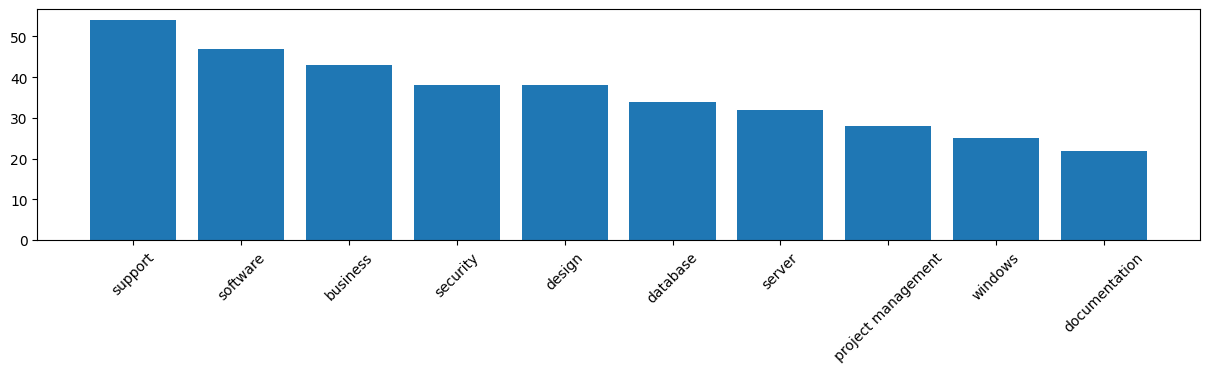

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name entity recognition

In [70]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [37]:
doc = nlp(text)

In [38]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [42]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

## 7. Lets load the pdf - Add Some Realism

In [45]:
pip install PyPDF2


   ---------------------------------------- 232.6/232.6 kB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [78]:
from PyPDF2 import PdfReader
from spacy import displacy

# Step 1: Read and preprocess the resume text
reader = PdfReader("SaijalCV.pdf")
page = reader.pages[0]  # first page, for demo purposes
text = page.extract_text()
cleaned_text = preprocessing(text)  # Preprocess the text

# Step 2: Extract information from the cleaned resume text
processed_info = process_resume(cleaned_text)  # Process the resume

# Step 3: Visualize the processed information
# For demonstration, let's assume we want to visualize the skills within the processed text
doc = nlp(cleaned_text)  # Re-process the cleaned text with spaCy to get a Doc object for visualization
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc, style="ent", options=options)  # Visualize entities


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8784\365495833.py:50: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  if token.similarity(skill_doc) > 0.7:  # Threshold for similarity


## Applying it on Chaklam's Resume

In [77]:
from PyPDF2 import PdfReader
from spacy import displacy

# Step 1: Read and preprocess the resume text
reader = PdfReader("chaklam_resume.pdf")
page = reader.pages[0]  # first page, for demo purposes
text = page.extract_text()
cleaned_text = preprocessing(text)  # Preprocess the text

# Step 2: Extract information from the cleaned resume text
processed_info = process_resume(cleaned_text)  # Process the resume

# Step 3: Visualize the processed information
# For demonstration, let's assume we want to visualize the skills within the processed text
doc = nlp(cleaned_text)  # Re-process the cleaned text with spaCy to get a Doc object for visualization
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc, style="ent", options=options)  # Visualize entities


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8784\365495833.py:50: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  if token.similarity(skill_doc) > 0.7:  # Threshold for similarity
